# Transforming between coordinate systems and planning observations <img src='images/logo.png' width=250px align='right'>
Now let's say something excites you about one of the objects in the catalogs that you explored in the previous notebook, and you want to know if and when you might go about observing it.  `astropy.coordinates` provides tools to enable this, as well.

In [8]:
# Tools for connecting with web servers
import urllib
# Utilities for displaying images in jupyter notebooks
import IPython.display
# Numpy, what else can I say?
import numpy as np

In [9]:
# Display images in the browser window
%matplotlib inline
# Matplotlib, what else can I say?
from matplotlib import pyplot as plt

In [10]:
# Utilities particular to astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table

In [11]:
hcg7_center = SkyCoord(9.81625*u.deg, 0.88806*u.deg, frame='icrs')
print(hcg7_center)

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88806)>


### Introducting frame transformations

To understand the code in this section, it may help to read over the [overview of the astropy coordinates scheme](http://astropy.readthedocs.org/en/latest/coordinates/index.html#overview-of-astropy-coordinates-concepts).  The key bit to understand is that all coordinates in astropy are in particular "frames", and we can transform between a specific `SkyCoord` object from one frame to another.

Here we will transform our previously-defined center of HCG7 from ICRS to Galactic coordinates. Galactic coordinates are defined in relationship to the Solar System's location in the Milky Way Galaxy. The two angular coordinates are longitude and latitude, where the Galactic center is defined as being at 0 longitude and zero latitude.

The following picture shows how it works.
<img src='images/GalacticCoords.jpg' align='center' width=500px>

Of course, the orientation of the Solar System with respect to the Galaxy is something arbitrary and not easy to imagine (63 degrees from the celestial equator). However, this picture shows how these things all overlap.
<img src='images/GC_EC.gif' align='center' width=400px>

So, thank goodness for these routines that will do the conversion automatically for us.

In [12]:
hcg7_center.galactic

<SkyCoord (Galactic): (l, b) in deg
    (116.47556813, -61.83099472)>

The above is actually a special "quick-access" form which internally does the same as what's in the cell below: uses the `transform_to()` method to convert from one frame to another.

In [13]:
from astropy.coordinates import Galactic
hcg7_center.transform_to(Galactic())

<SkyCoord (Galactic): (l, b) in deg
    (116.47556813, -61.83099472)>

Note that changing frames also changes some of the attributes of the object, but usually in a way that makes sense:

In [14]:
# hcg7_center.galactic.ra  # this should fail because galactic coordinates are l/b not RA/Dec

In [15]:
hcg7_center.galactic.b

<Latitude -61.83099472 deg>

In [16]:
hcg7_center

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88806)>

### Using frame transformations to get to AltAz

Lastly, we will want to know what the Altitude and Azimuth of a target is (since this is how our telescope works). It is important to note that we will first need to specify both where the object is <b>and when</b> we want to try to observe.

In [17]:
from astropy.coordinates import EarthLocation
from astropy.time import Time

observing_location = EarthLocation(lat='34d28m00.5s', lon='-119d10m38.5s', height=494.7*u.m)
# These are the GPS coordinates for the Thacher Observatory

# If you're using astropy v1.1 or later, you can also find the coordinates of known professional observatories
# with a line like:
#observing_location = EarthLocation.of_site('Kitt Peak')

observing_time = Time('2022-10-01 02:00')  # 2am UTC = 6pm PST

Now we use these to create an `AltAz` frame object.  Note that this frame has some other information about the atmosphere, which can be used to correct for atmospheric refraction.  Here we leave that alone, because the default is to ignore this effect (by setting the pressure to 0).

In [18]:
from astropy.coordinates import AltAz

aa = AltAz(location=observing_location, obstime=observing_time)
aa

<AltAz Frame (obstime=2022-10-01 02:00:00.000, location=(-2566538.72797699, -4596544.14091945, 3589536.623612) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron)>

Now we can just transform our ICRS `SkyCoord` to `AltAz` to get the location in the sky over Thacher Observatory at the requested time.

In [19]:
hcg7_center.transform_to(aa)

<SkyCoord (AltAz: obstime=2022-10-01 02:00:00.000, location=(-2566538.72797699, -4596544.14091945, 3589536.623612) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (89.44883218, 0.98864282)>

###### Alright, it's up at 6pm, but it's pretty low in the sky. Lets try to create an airmass plot to find a more optimal time to observe it.

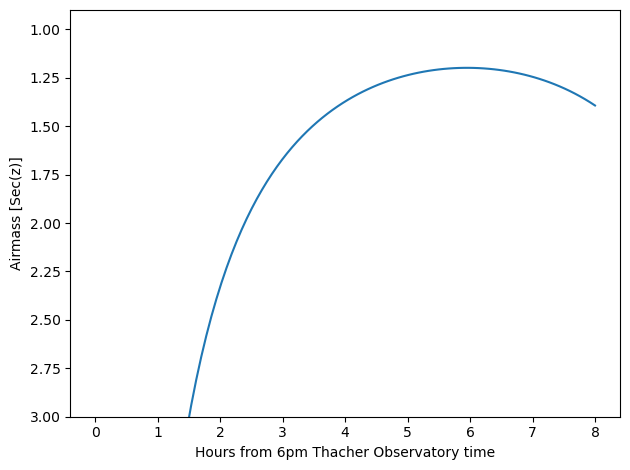

In [20]:
# this gives a Time object with an *array* of times
delta_hours = np.linspace(0, 8, 100)*u.hour
full_night_times = observing_time + delta_hours
full_night_aa_frames = AltAz(location=observing_location, obstime=full_night_times)
full_night_aa_coos = hcg7_center.transform_to(full_night_aa_frames)

plt.plot(delta_hours, full_night_aa_coos.secz)
plt.xlabel('Hours from 6pm Thacher Observatory time')
plt.ylabel('Airmass [Sec(z)]')
plt.ylim(3,0.9)
plt.tight_layout()

Great!  Looks like it's at the lowest airmass in another 5 hours or so (1am).  

Another question you might ask yourself is, "would it be dark enough at 8pm to observe at all?" Fortunately, astropy provides a ``get_sun`` function that can be used to check this.  Lets use it to see when 18-degree twilight ends.

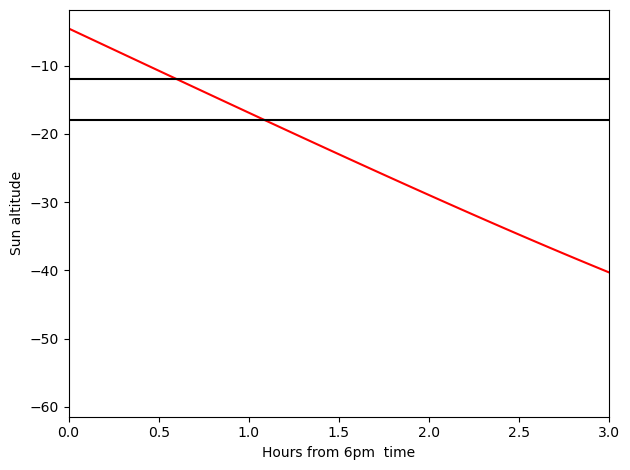

In [51]:
from astropy.coordinates import get_sun

full_night_sun_coos = get_sun(full_night_times).transform_to(full_night_aa_frames)
plt.plot(delta_hours, full_night_sun_coos.alt.deg, color='r')
plt.axhline(-18, color='k')
plt.axhline(-12, color='k')
plt.xlim(0,3)
plt.xlabel('Hours from 6pm  time')
plt.ylabel('Sun altitude')
plt.tight_layout()

Try converting the HCG7 coordinates to an equatorial frame at some other equinox a while in the past (like J2000).  Do you see the precession of the equinoxes?

Hint: To see a diagram of the supported frames look [here](http://docs.astropy.org/en/stable/coordinates/#module-astropy.coordinates).  One of those will do what you need if you give it the right frame attributes.

In [37]:
from astropy.coordinates import FK5

#Convert HCG7 coordinates to J2000
hcg7_center_j2000 = hcg7_center.transform_to(FK5(equinox='J1950'))
print(hcg7_center_j2000)

<SkyCoord (FK5: equinox=J1950.000): (ra, dec) in deg
    (9.17517211, 0.61348823)>


Looks like the Sun is below the horizon at 6pm, but dips below the -18 degree astronomical twilight limit at about 7pm. So, best to start your observations a bit before 7pm.

### Exercises

Try to actually compute to some arbitrary precision (rather than eye-balling on a plot) when 18 degree twilight or sunrise/sunset hits on that night.

In [78]:
#Find when the Sun is at -18 degrees altitude, and convert to local time
sun_alt = get_sun(full_night_times).transform_to(full_night_aa_frames).alt.deg

#Find the first time the Sun is at -18 degrees altitude
sun_alt_18 = np.where(sun_alt < -18)[0][0]

print(delta_hours[sun_alt_18])
#The sun will set 1.13 hours after 6pm


1.1313131313131315 h


## Wrap-up

For lots more documentation on the many other features of `astropy.coordinates`, check out [its section of the documentation](http://astropy.readthedocs.org/en/latest/coordinates/index.html).

Hopefully this has been an instructive exercise to orient you with astronmical coordinates. In practice, some of the features offered by astropy.coordinates will be usurped by using software such as [iObserve](https://itunes.apple.com/us/app/iobserve/id424693907?mt=12), a highly recommended (and free!) app for observational planning. 

You might also be interested in [the astroplan affiliated package](http://astroplan.readthedocs.org/), which uses the `astropy.coordinates` to do more advanced versions of the tasks in the last section of this tutorial.